#設定

In [ ]:
!pip install japanize-matplotlib

In [27]:
import mpmath
from matplotlib import rc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from scipy import stats
import copy
import pandas as pd
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm

# 3.1

In [3]:
scores = pd.read_csv("/content/student_score.txt", delimiter=" ")

## 表3.1

In [4]:
scores.head(11)

,mech,vecs,alg,analy,stat
0,7,51,43,17,22
1,44,69,53,53,53
2,49,41,61,49,64
3,59,70,68,62,56
4,34,42,50,47,29
5,46,40,47,29,17
6,0,40,21,9,14
7,32,45,49,57,64
8,49,57,47,39,26
9,52,64,60,63,54


## mecanicsとvectorsの標本相関係数

In [5]:
corr = scores.corr()
theta_hat = corr.loc["mech", "vecs"]
print("theta_hat = {:>0.3f}".format(theta_hat))

theta_hat = 0.498


##図3.2

### 図3.2を描くための計算

$
\begin{aligned}
    f_\theta(\hat{\theta})
    &= \frac{(n - 2)(1 - \theta^2)^{(n - 1) / 2}(1 - \hat{\theta}^2)^{(n - 4)/2}}{\pi} \int_0^\infty \frac{dw}{(\cosh w - \theta \hat{\theta})^{n - 1}} \\
    &= \frac{20}{\pi} (1 - \theta^2)^{10.5}(1 - \hat{\theta}^2)^9 \int_0^\infty \frac{dw}{(\cosh w - \theta \hat{\theta})^{21}}
\end{aligned}
$

 $ \displaystyle g(\mu | x) = \frac{ g(\mu) f_\mu(x) }{ f(x) }$ , $ \displaystyle f(x) = \int_\Omega f_\mu(x)g(\mu) d\mu $

#### flat prior

$ g(\theta) = \frac{1}{2}$ for $ -1 \leq \theta \leq 1 $

$
\begin{aligned}
f(\hat{\theta})
&= \int_{-1}^1 \frac{10}{\pi} (1 - \theta^2)^{10.5}(1 - \hat{\theta}^2)^9 \int_0^\infty \frac{dw}{(\cosh w - \theta \hat{\theta})^{21}} d\theta \\
&= \int_{-1}^1 \int_0^\infty \frac{10 (1 - \theta^2)^{10.5}(1 - \hat{\theta}^2)^9}{\pi (\cosh w - \theta \hat{\theta})^{21}} dw d\theta \\
&= \int_0^\infty \int_{-1}^1 \frac{f_\text{numer}}{f_\text{denom}} d\theta dw \\
\end{aligned}
$

In [6]:
f_numer = lambda theta, w: 10 * (1 - theta**2)**10.5 * (1 - theta_hat**2)**9
f_denom = lambda theta, w: np.pi * (mpmath.cosh(w) - theta * theta_hat)**21
f = lambda theta, w: f_numer(theta, w) / f_denom(theta, w)

In [7]:
post_denom_flat = mpmath.quad(f, [-1, 1], [0, float("inf")])
post_denom_flat = float(post_denom_flat)

In [8]:
def posterior_flat(theta):
    global theta_hat
    g = 0.5
    f_coef = (20 / np.pi) * (1 - theta**2)**10.5 * (1 - theta_hat**2)**9
    f_integrand = lambda w: 1 / mpmath.power(mpmath.cosh(w) - theta * theta_hat, 21)
    f_integral = mpmath.quad(f_integrand, [0, float("inf")])
    return g * f_coef * f_integral / post_denom_flat

#### Jeffrey's prior

$ g^{\text{Jeff}}(\theta) = 1 / (1 - \theta^2) $

$
\begin{aligned}
f(\hat{\theta})
&= \int_{-1}^1 \frac{20}{(1 - \theta^2)\pi} (1 - \theta^2)^{10.5}(1 - \hat{\theta}^2)^9 \int_0^\infty \frac{dw}{(\cosh w - \theta \hat{\theta})^{21}} d\theta \\
&= \int_{-1}^1 \int_0^\infty \frac{20(1 - \theta^2)^{9.5}(1 - \hat{\theta}^2)^9}{\pi(\cosh w - \theta \hat{\theta})^{21}} dw d\theta \\
&= \int_0^\infty \int_{-1}^1 \frac{f_\text{numer}}{f_\text{denom}} d\theta dw \\
\end{aligned}
$

In [9]:
f_numer = lambda theta, w: 20 * (1 - theta**2)**9.5 * (1 - theta_hat**2)**9
f_denom = lambda theta, w: np.pi * (mpmath.cosh(w) - theta * theta_hat)**21
f = lambda theta, w: f_numer(theta, w) / f_denom(theta, w)

In [10]:
post_denom_jeff = mpmath.quad(f, [-1, 1], [0, float("inf")])
post_denom_jeff = float(post_denom_jeff)

In [11]:
def posterior_jeff(theta):
    global theta_hat
    g = 1 / (1 - theta**2)
    f_coef = (20 / np.pi) * (1 - theta**2)**10.5 * (1 - theta_hat**2)**9
    f_integrand = lambda w: 1 / mpmath.power(mpmath.cosh(w) - theta * theta_hat, 21)
    f_integral = mpmath.quad(f_integrand, [0, float("inf")])
    return g * f_coef * f_integral / post_denom_jeff

#### Triangular prior

$ g(\theta) = 1 - |\theta| $

$
\begin{aligned}
f(\hat{\theta})
&= \int_{-1}^1 \frac{20(1 - |\theta|)}{\pi} (1 - \theta^2)^{10.5}(1 - \hat{\theta}^2)^9 \int_0^\infty \frac{dw}{(\cosh w - \theta \hat{\theta})^{n - 1}} d\theta \\
&= \int_{-1}^1 \int_0^\infty \frac{20(1 - |\theta|)(1 - \theta^2)^{10.5}(1 - \hat{\theta}^2)^9}{\pi(\cosh w - \theta \hat{\theta})^{21}} d\theta \\
&= \int_0^\infty \int_{-1}^1 \frac{f_\text{numer}}{f_\text{denom}} d\theta dw \\
\end{aligned}
$

In [12]:
f_numer = lambda theta, w: 20 * (1 - np.abs(theta)) * (1 - theta**2)**10.5 * (1 - theta_hat**2)**9
f_denom = lambda theta, w: np.pi * (mpmath.cosh(w) - theta * theta_hat)**21
f = lambda theta, w: f_numer(theta, w) / f_denom(theta, w)

In [13]:
post_denom_tria = mpmath.quad(f, [-1, 1], [0, float("inf")])
post_denom_tria = float(post_denom_tria)

In [14]:
post_denom_tria

0.546374151201319

In [15]:
def posterior_tria(theta):
    global theta_hat
    g = 1 - np.abs(theta)
    f_coef = (20 / np.pi) * (1 - theta**2)**10.5 * (1 - theta_hat**2)**9
    f_integrand = lambda w: 1 / mpmath.power(mpmath.cosh(w) - theta * theta_hat, 21)
    f_integral = mpmath.quad(f_integrand, [0, float("inf")])
    return g * f_coef * f_integral / post_denom_tria

### 図3.2の描画

In [16]:
x = np.arange(-0.2, 0.99, 0.01)
y_flat = [posterior_flat(xval) for xval in x]
y_jeff = [posterior_jeff(xval) for xval in x]
y_tria = [posterior_tria(xval) for xval in x]

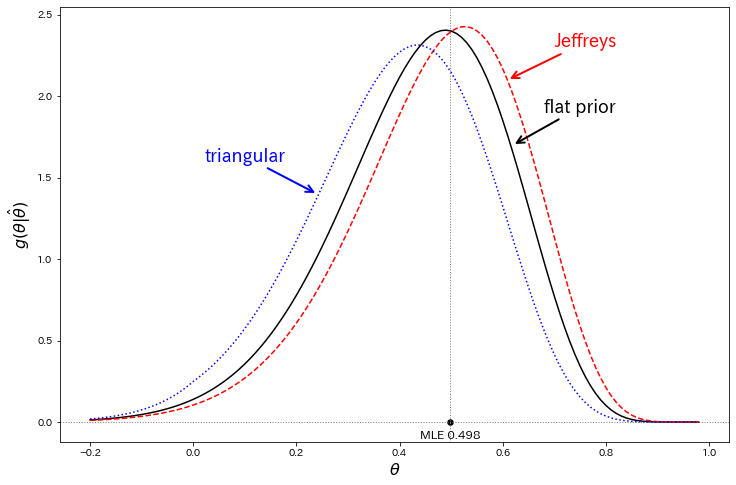

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.axhline(0, c="gray", linestyle=":", linewidth=1)
ax.axvline(theta_hat, c="gray", linestyle=":", linewidth=1)

ax.plot(x, y_flat, c="k")
ax.annotate(
    "flat prior",
    size=18,
    xy=(0.62, 1.7),
    xytext=(0.75, 1.9),
    arrowprops=dict(arrowstyle="->", linewidth=2),
    horizontalalignment="center",
)

ax.plot(x, y_jeff, c="r", linestyle="--")
ax.annotate(
    "Jeffreys",
    size=18,
    xy=(0.61, 2.1),
    xytext=(0.76, 2.3),
    arrowprops=dict(arrowstyle="->", color="r", linewidth=2),
    horizontalalignment="center",
    color="r",
)

ax.plot(x, y_tria, c="b", linestyle=":")
ax.annotate(
    "triangular",
    size=18,
    xy=(0.24, 1.4),
    xytext=(0.1, 1.6),
    arrowprops=dict(arrowstyle="->", color="b", linewidth=2),
    horizontalalignment="center",
    color="b"
)

ax.scatter([theta_hat], [0], c="k", s=30)
ax.text(
    theta_hat,
    -0.1,
    "MLE {:.3f}".format(theta_hat),
    fontsize=12,
    horizontalalignment="center",
    color="k"
)

ax.set_xlabel(r"$\theta$", size=16)
ax.set_ylabel(r"$g(\theta|\hat{\theta})$", size=16);

# 3.3

In [18]:
prostate = pd.read_csv("/content/prostmat.csv")

In [19]:
prostate.head()

,control,control.1,control.2,control.3,control.4,control.5,control.6,control.7,control.8,control.9,...,cancer.42,cancer.43,cancer.44,cancer.45,cancer.46,cancer.47,cancer.48,cancer.49,cancer.50,cancer.51
0,-0.930895,-0.751885,-0.545781,-1.078519,-0.994677,0.015547,-0.853963,4.016860,-0.399641,-1.085050,...,-0.845358,0.936035,-0.819505,-0.849670,0.434865,2.054122,2.799498,1.294162,2.905588,3.434504
1,-0.839996,-0.848271,-0.851687,-0.159610,-0.751905,-0.516436,-0.826845,-0.832741,-0.840731,-0.824386,...,0.563857,-0.439367,2.052858,0.441992,0.675806,-0.450853,1.385720,-1.143997,-0.282119,-1.174233
2,0.062508,0.102895,-0.003043,0.215347,-1.163109,1.028130,-0.476408,-1.154759,-1.161665,-0.690671,...,-0.007371,0.629820,-1.107093,-0.968790,-0.235357,-1.049600,1.186599,0.962634,-0.026753,1.533532
3,-0.361594,2.421034,-0.122089,-0.096277,-1.130144,0.458272,0.633883,0.069708,-1.128592,-0.429663,...,-0.508988,-0.409035,0.557853,-0.900065,1.491239,0.553022,0.118476,1.220066,-1.138651,0.174831
4,-1.124427,0.182211,0.837907,1.050548,1.695673,3.463900,-1.109246,-0.310570,-0.105437,-1.072878,...,0.524438,-1.172145,0.936470,0.683947,-0.618465,3.995967,0.115477,-1.167392,-1.195660,-0.203642


In [22]:
prostz = pd.read_csv("/content/prostz.txt", header=None, names=["z"])

In [24]:
prostz

,z
0,1.472367
1,3.572915
2,-0.027754
3,-1.132052
4,-0.140221
...,...
6028,0.287357
6029,-0.777423
6030,-1.183667
6031,0.103544


In [37]:
print("x_610: {:>1.2f}".format(prostz.z[609]))

x_610: 5.29


## 図3.4

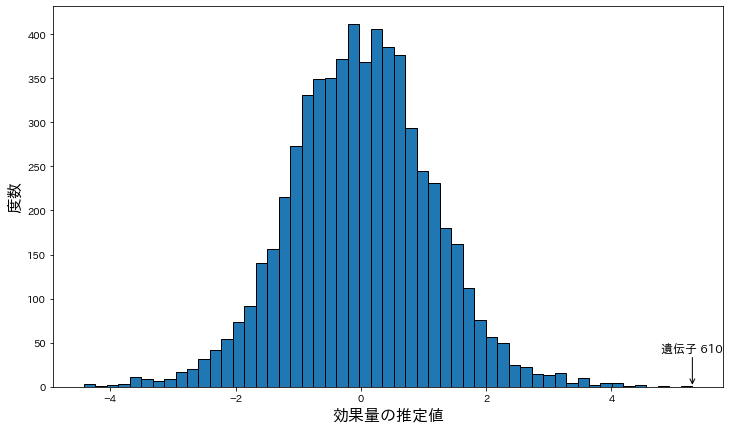

In [36]:
fig, ax = plt.subplots(figsize=(12, 7))

z = prostz['z'] 
ax.hist(z, bins=53, edgecolor="k")
ax.annotate(
    "遺伝子 610",
    size=12,
    xy=(z[609], 0),
    xytext=(z[609], 40),
    arrowprops=dict(arrowstyle="->", facecolor="black"),
    horizontalalignment="center",
)
ax.set_xlabel("効果量の推定値", size=16)
ax.set_ylabel("度数", size=16);